一直以來，支持向量機都是科學中最受歡迎的分類演算法。更特別的是，台大的林智仁老師所開發的支持向量機是最被廣泛使用的軟體。其實在Python裡的支持向量機，用的就是林教授所開發的LIBSVM的版本，LIBSVM至今已被下載超過一一五萬次，是台灣之光。

支持向量機的專業數學公式就不在本書說明，白話說明其背後主要原理：
1. 找出一個線性的平面，試圖將不同類別之間的距離最大化(請注意此為簡化說明，內容不見得足夠精確)
2. 如果無法做分線性分割，就將不同類別的資料投射至高維度空間再做分割。你可以想像二維的資料無法做線性分割成兩類，將資料投射至3度空間再分割就能解決在二維空間無法分割的問題了。

Python裡的支持向量機，透過kernel(核心)參數的選擇可分為線性'linear'和非線性'rbf'支持向量機，其主要有兩個參數：
1. C：C值是錯誤分類的處罰。當C值大時，表示不允許分類錯誤的發生，其模型複雜度會提升。通常會提升正確率，但C過大時也會造成過度擬合的問題(overfitting)。反之，當C值小時能允許錯誤分類，通常會降低些正確率，但其一般化(generalization)的程度也會較好。因此，C的選擇不能太大，也不能太小。
2. 另一個參數是gamma，僅用在kernel為'rbf'的情形使用。當kernel為rbf時，會將資料映射到高維度空間，gamma值則影響資料投射的情況。以幾何的觀點來看，當gamma值增加時，會讓Radial Basis Function(RBF)裡面的σ變小，而σ很小的高斯分佈會又高又瘦只讓在附近的資料點有所作用。通常會提升正確率，但gamma過大時，同樣會造成過度擬合的問題。反之，當gamma變小，資料點的影響力範圍比較遠。因此能勾勒出平滑、近似直線的超平面，預測結果的一般化程度會比較好。  

本章用的資料是鐵達尼號的資料。如果說鳶尾花是資料學習的入門資料，那鐵達尼號絕對是最被常研究的資料。各位如果上網去找就可以發現有多少程式都是針對鐵達尼號的沉船在做預測。

## 1 載入資料
資料來源是從kaggle網站下載，我們僅用訓練集資料，因為只有訓練集資料有目標值。

In [ ]:
! wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1SsEqeMh-CdTxnfyARliTKjzK5ykzrk8q" -O titanic_train.csv

--2023-03-08 07:21:50--  https://drive.google.com/uc?export=download&id=1SsEqeMh-CdTxnfyARliTKjzK5ykzrk8q
Resolving drive.google.com (drive.google.com)... 142.251.8.100, 142.251.8.113, 142.251.8.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.8.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/slj98b7eg0b66evnceov71sv8vdcmr1s/1678260075000/12753731852601416608/*/1SsEqeMh-CdTxnfyARliTKjzK5ykzrk8q?e=download&uuid=e4db9ba2-4413-4684-85c5-b05b4d2f9464 [following]
--2023-03-08 07:21:52--  https://doc-08-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/slj98b7eg0b66evnceov71sv8vdcmr1s/1678260075000/12753731852601416608/*/1SsEqeMh-CdTxnfyARliTKjzK5ykzrk8q?e=download&uuid=e4db9ba2-4413-4684-85c5-b05b4d2f9464
Resolving doc-08-6k-docs.googleusercontent.com (doc-08-6k-docs.googleusercontent.com)... 142.250.157.132, 2404:680

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['DFKai-sb']
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('titanic_train.csv')
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


範例： 資料檢查和資料欄位說明    
用df.info()指令來完成這項工作，資料共891筆。  

* PassengerID，是無意義欄位，可移除
* Survived，是存活與否(1為獲救，0為未獲救)，是我們的目標預測值
* Pclass，是船艙等級，有三個等級，分別是123
* Name，名字，可移除
* Sex，性別，在資料裡屬類別型變數，有male和female
* Age，年齡，只有714筆，顯然有遺漏值
* SibSp，(sibling and spouse)兄弟姐妹和配偶人數，是數值型資料
* Parch，(parents and children)父母和小孩人數，亦是數值型資料
* Ticket，船票資訊，不在本次分析，會刪除
* Fare，船票價格，是數值型資料
* Cabin，僅204筆資料，遺漏值過多，會刪除
* Embarked，登船港口為類別型資料，共有三個上船點(C: Cherbourg, Q:Queenstown, S:Southampton)

很顯然地，這筆資料比起鳶尾花來得複雜。我們面對的問題有遺漏值，連續型和類別型資料的分別處理。因此，我們可以預想最少要兩個管道器來分別處理連續型和類別型資料。學完這個例子。你就已經具備分析一般真實數據的能力了。

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
pd.concat([df['Survived'].value_counts(),
          df['Survived'].value_counts(normalize=True)],
          axis=1, keys=['個數','百分比'])

,個數,百分比
0,549,0.616162
1,342,0.383838


In [ ]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

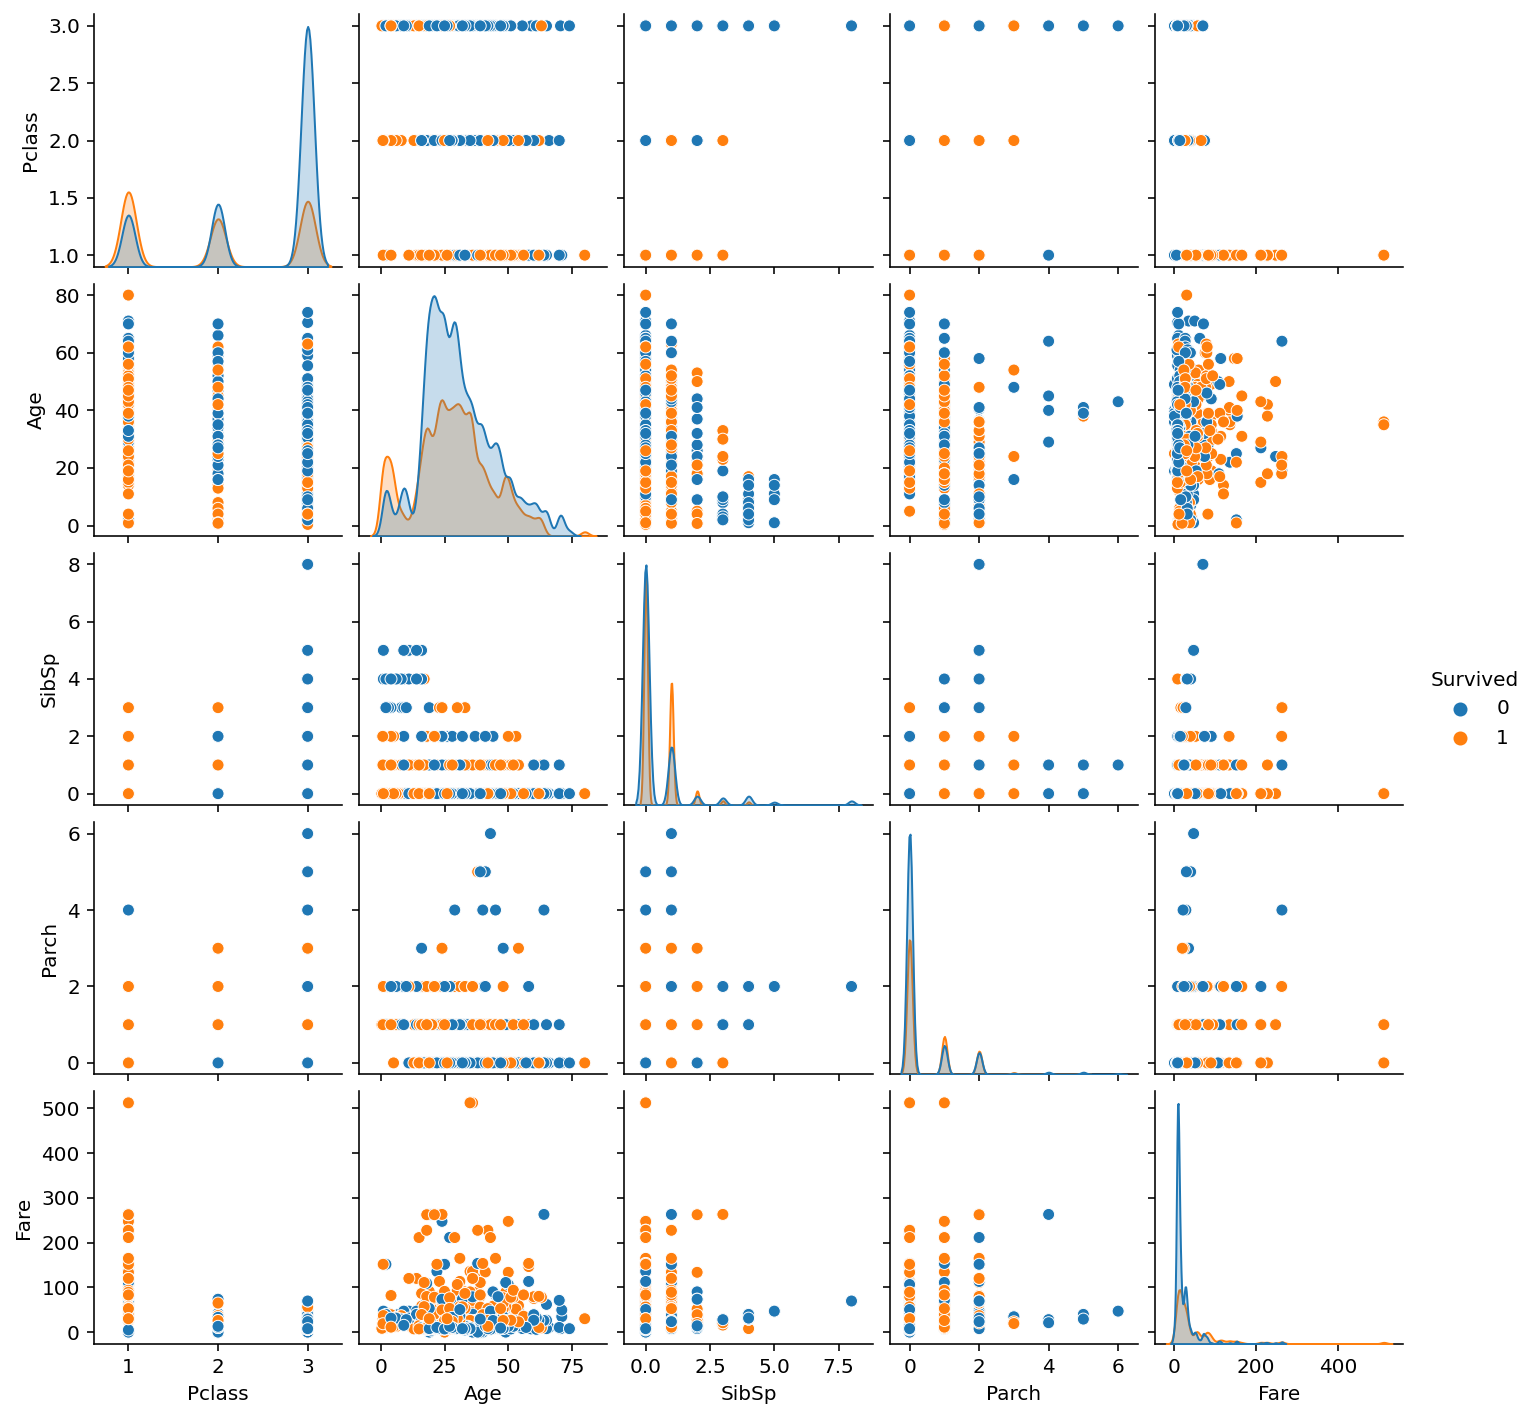

In [ ]:
sns.pairplot(data=df, hue='Survived',
             size=2, diag_kws={'bw':0.1});

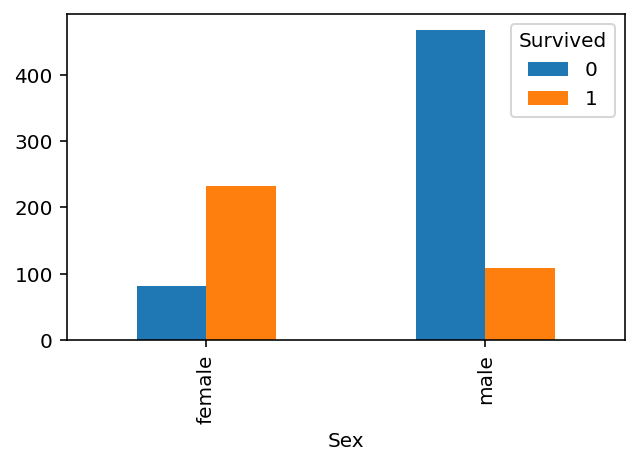

In [ ]:
df.groupby('Sex')['Survived'].value_counts().\
unstack(1).plot(kind='bar', figsize=(5,3));

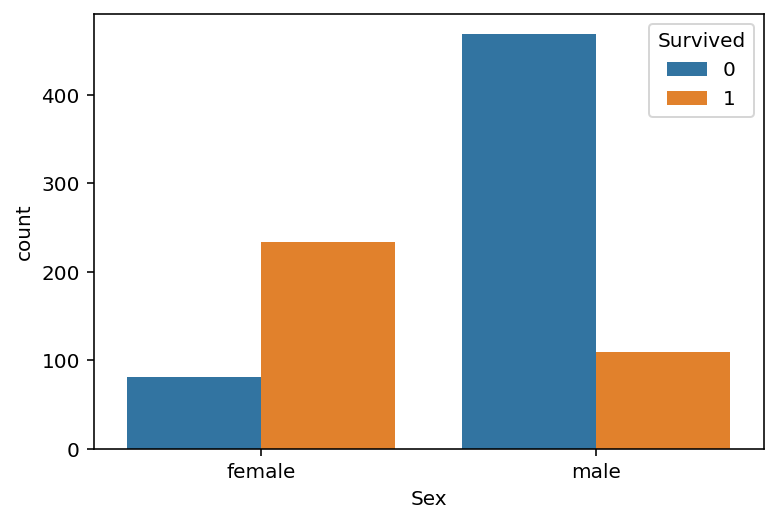

In [ ]:
sns.countplot(x='Sex', order=['female','male'],
              hue='Survived', data=df);

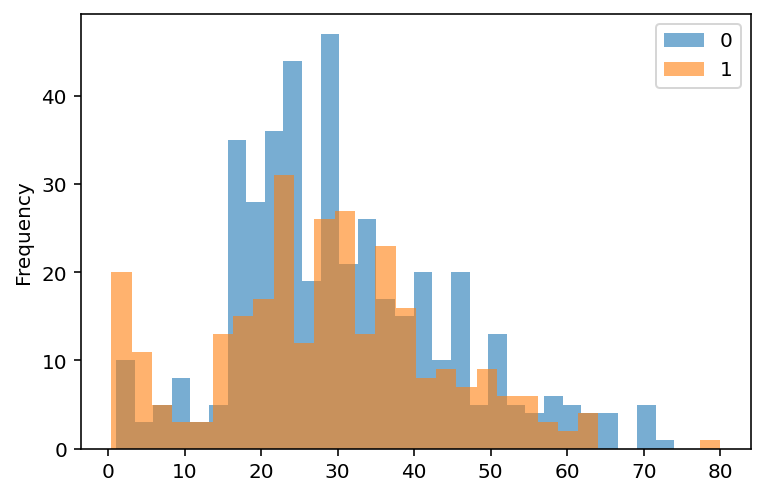

In [ ]:
df.groupby('Survived')['Age'].plot(kind='hist', alpha=0.6,
                                   bins=30, legend=True);

In [ ]:
X_col_num = ['Age', 'SibSp', 'Parch', 'Fare']
X_col_cat = ['Pclass', 'Sex', 'Embarked']
X_cols = X_col_num + X_col_cat
y_col = 'Survived'

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
num_pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
#檢查數值管道器的運作
print(f'數值型資料的欄位有：{X_col_num}')
num_pl.fit_transform(df[X_col_num])[:3]

數值型資料的欄位有：['Age', 'SibSp', 'Parch', 'Fare']


array([[-0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [ 0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [-0.25833709, -0.4745452 , -0.47367361, -0.48885426]])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_pl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False)
)
# 檢查類別管道器的運作
cat_pl.fit_transform(df[X_col_cat])[:3]

array([[0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.]])

In [ ]:
oh = cat_pl.named_steps['onehotencoder']
oh_cols = oh.get_feature_names_out(X_col_cat)
oh_cols

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype=object)

In [ ]:
pd.DataFrame(cat_pl.fit_transform(df[X_col_cat]),
             columns=oh_cols).head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
from sklearn.compose import ColumnTransformer
data_pl = ColumnTransformer([
    ('num_pl', num_pl, X_col_num),
    ('cat_pl', cat_pl, X_col_cat)
])
data_pl.fit_transform(df[X_cols])[:1].round(2)

array([[-0.57,  0.43, -0.47, -0.5 ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  1.  ]])

In [ ]:
from sklearn.model_selection import train_test_split
X = df[X_cols]
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.33, random_state=42)

In [ ]:
from sklearn.svm import SVC
model_pl_svc = make_pipeline(data_pl, SVC())
model_pl_svc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pl',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat_pl',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('svc', SVC())])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
model_pl_svc.fit(X_train, y_train)
y_pred = model_pl_svc.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

正確率： 0.83
混亂矩陣
[[158  17]
 [ 32  88]]
綜合報告
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       175
           1       0.84      0.73      0.78       120

    accuracy                           0.83       295
   macro avg       0.83      0.82      0.82       295
weighted avg       0.83      0.83      0.83       295



In [ ]:
from sklearn.linear_model import LogisticRegression
model_pl_lr = make_pipeline(data_pl, LogisticRegression())
model_pl_lr.fit(X_train, y_train)
y_pred = model_pl_lr.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

正確率： 0.81
混亂矩陣
[[154  21]
 [ 35  85]]
綜合報告
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       175
           1       0.80      0.71      0.75       120

    accuracy                           0.81       295
   macro avg       0.81      0.79      0.80       295
weighted avg       0.81      0.81      0.81       295



In [ ]:
data_pl = ColumnTransformer([
    ('num_pl', num_pl, ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
    ('cat_pl', cat_pl, ['Sex', 'Embarked'])
])
model_pl_svc = make_pipeline(data_pl, SVC())
model_pl_svc.fit(X_train, y_train)
y_pred = model_pl_svc.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))

正確率： 0.84
混亂矩陣
[[159  16]
 [ 32  88]]


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
data_pl = ColumnTransformer([
    ('num_pl', num_pl, X_col_num),
    ('cat_pl', cat_pl, X_col_cat)
])
model_pl_svc = make_pipeline(data_pl,
                             SelectKBest(f_classif, k=3),
                             SVC())
model_pl_svc.fit(X_train, y_train)
y_pred = model_pl_svc.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))

正確率： 0.77
混亂矩陣
[[170   5]
 [ 62  58]]


In [ ]:
# 先取到所有欄位名稱含獨熱編碼的欄位
cols = X_col_num + oh_cols.tolist()
selector = model_pl_svc.named_steps['selectkbest']
# 先將資料變成array的資料型態，再用布林值取出欄位名稱
np.array(cols)[selector.get_support()]

array(['Pclass_3', 'Sex_female', 'Sex_male'], dtype='<U10')

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
# 欄位
X_col_num = ['Fare', 'Age']
X_col_bin = ['SibSp', 'Parch']
X_col_cat = ['Pclass', 'Sex', 'Embarked']
# 資料管道器
num_pl = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
bin_pl = make_pipeline(
    SimpleImputer(strategy='mean'),
    KBinsDiscretizer(n_bins=5, encode='ordinal'),
)
cat_pl = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder()
)
# 合併後的資料管道器
data_pl = ColumnTransformer([
    ('num', num_pl, X_col_num),
    ('bin', bin_pl, X_col_bin),
    ('cat', cat_pl, X_col_cat)
])
# 模型預測
model_pl = make_pipeline(data_pl, SVC())
model_pl.fit(X_train, y_train)
y_pred = model_pl.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('整體正確率:',accuracy_score(y_test, y_pred).round(2))

[[163  12]
 [ 45  75]]
整體正確率: 0.81


## 作業

先用以下程式碼載入資料


df = pd.read_csv('titanic_train.csv')  
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)  
X = df.drop('Survived', axis=1)  
y = df['Survived']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
                                                   

1. 請做出三個資料管道器
    * log_pl包含遺漏值(平均值), FunctionTransformer(np.log1p), 標準差
    * num_pl包含遺漏值(平均值), 標準差
    * cat_pl包含遺漏值(用常數'missing'), 獨熱編碼
    
其中['Age','Fare']去log_pl，['SibSp','Parch','Pclass']去num_pl，['Sex','Embarked']去cat_pl，請問最後的正確率是多少？

2. 承上，將支持向量機改為K最近鄰法來做預測  